In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Výchozí myšlenka raketové rovnice 
$$
\frac{dp}{dt} = \sum{i}F_{i}
$$
Kde p je hybnost rakety a F_i součet sil působících na raketu. Hybnost rakety je rovna:
$$
p = m(t)v(t), dp= vdm + mdv 
$$
Kde $m(t)$ je závislost hmotnosti rakety na čase. Neboť víme, že raketa získává hlavní část své rychlosti "vystřelováním" paliva o jisté hybnosti proti směru pohybu, musíme ještě přidat člen:
$$
dp = -dm(v-v_{p})
$$
Po úpravě:
$$
\frac{dp}{dt} = m\frac{dv}{dt} + v_{p} \frac{dm}{dt} 
$$

# Silová část
Uvažujeme, že na raketu působí 2 síly, přičemž obě působí proti směru rakety, jsou jimi:

$$
F =-m(t)g - pv^{2} 
$$

Kde p je koeficient odporu vzduchu
Když dáme rovnice dohromady a upravíme získáme  rovnici:

$$
\frac{dv}{dt} = -g- \frac{b}{m(t)} v^{2} - \frac{v_p dm(t)}{m(t)dt}
$$

# Standardizace - pro usnadnění výpočtu
Abychom usnadnili výpočet pro počítač provedeme jisté úpravy rovnice. Jmenovitě členy rychlosti $v$, času $t$ a hmotnosti upravíme tak, aby se pohybovaly mezi 0 a 1. Po úpravě:
$$
\frac{dv'}{dt'}= - \frac{gT_{0}}{v_{p}} - \frac{v'^{2}}{m_{0}z(t')} - \frac{dz(t')}{z(t')dt'}
$$
Po úpravě nám stačí na počátku definovat, kolik bylo paliva při startu, funkci $z$ popisující jak rychle palivo z rakety vylétává (My počítáme s tím, že palivo vylétává rychlost $z(t') = 1-\frac{8}{10}t'^{n})$ - 80% hmotnosti rakety připadá na palivo) a konečně rychlost, s jakou z rakety vylétává.
## Poznámka:
$$
t' = \frac{t}{T0}
$$
$$
m(t) = m_{0}z(t)
$$
$$
v' = \frac{v}{v_p}
$$

$$
T_{0} = čas, ve kterém raketa vypustí všechno palivo
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import solve_ivp
import sympy as smp


In [53]:
# počáteční podmínky
T0 = 30
g = 9.81
vp = 1000
b = 0.2
M0 = 1e4
m0 = M0/(b*vp*T0)

In [54]:
#n = 1 #lineární vyhazování paliva
t= smp.symbols("t")
n = smp.symbols("n")
z = 1 - (8/10)*t**n
dzdt = smp.diff(z,t).simplify()
z = smp.lambdify([t,n],z) # převod na lamdbu pro urychlení výpočtu
dzdt = smp.lambdify([t,n],dzdt) # první parametr čas, druhý horní index

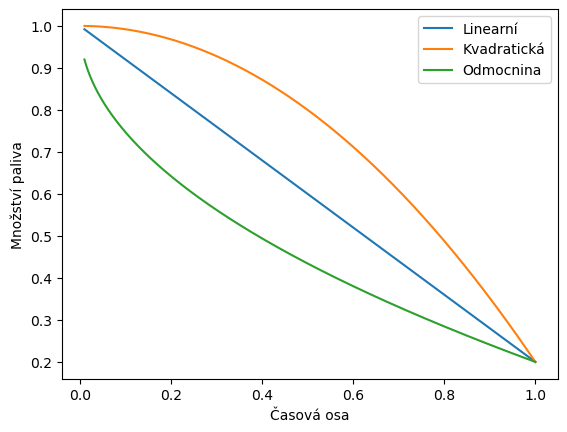

In [55]:
t = np.linspace(1e-2,1,1000)
zl = z(t,1) #lineární výpusť paliva
zk = z(t,2) #Druhá mocnica
zo = z(t,0.5) # Vyletování s odmocninou

plt.plot(t,zl,label="Linearní")
plt.plot(t,zk, label="Kvadratická")
plt.plot(t,zo,label="Odmocnina")
plt.xlabel("Časová osa")
plt.ylabel("Množství paliva")
plt.legend()

In [73]:
#Řešení ODE
# L = vektor jednotlivých proměnných
forces = []
def dLdt(t,L,m0,vp,n,T0=40):
    
    x,v = L[0],L[1]
    
    if t<1: #raketa má stále nějaké palivo
        dxdt = v
        dvdt = -g*T0/vp - 1/(m0*z(t,n))*v**2 *np.sign(v) -1/z(t,n)*dzdt(t,n)
        #forces.append(dvdt*m0*z(t,n))
    else:
        dxdt = v
        dvdt = -g*T0/vp - 1/(m0*z(1,n))*v**2 *np.sign(v)
        #forces.append(dvdt*m0*z(t,n))

    if (dvdt<0)*(dxdt<0)*(x<=0):
        dxdt=0
        dvdt=0
    return(dxdt,dvdt)

In [63]:
n1,n2,n3 = 1,0.5,2
mezea,mezeb = 1e-5,3
t_field = np.linspace(mezea,mezeb,10000)
r0 = [0,0] # polohový vektor počátku
solution1 = solve_ivp(dLdt,[mezea,mezeb],y0=r0,t_eval=t_field,args=(m0,vp,n1,T0))
solution2 =solve_ivp(dLdt,[mezea,mezeb],y0=r0,t_eval=t_field,args=(m0,vp,n2,T0))
solution3 = solve_ivp(dLdt,[mezea,mezeb],y0=r0,t_eval=t_field,args=(m0,vp,n3,T0))


Text(0, 0.5, 'Výška h (m)')

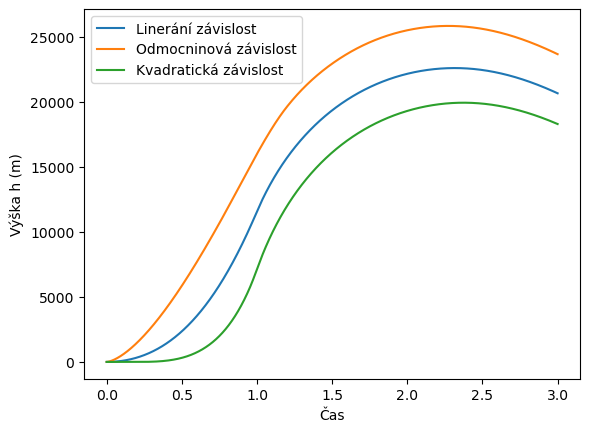

In [60]:
plt.plot(solution1.t,solution1.y[0]*vp*T0,label="Linerání závislost")
plt.plot(solution2.t,solution2.y[0]*vp*T0,label="Odmocninová závislost")
plt.plot(solution3.t,solution3.y[0]*vp*T0,label="Kvadratická závislost")
plt.xlabel("Čas")
plt.legend()
plt.ylabel("Výška h (m)")

Text(0, 0.5, 'Výška h (m)')

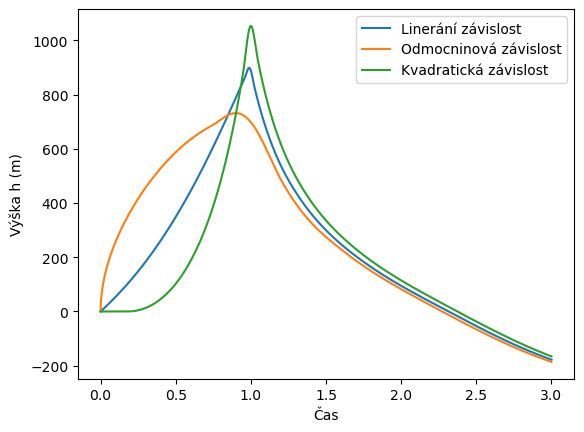

In [61]:
plt.plot(solution1.t,solution1.y[1]*vp,label="Linerání závislost")
plt.plot(solution2.t,solution2.y[1]*vp,label="Odmocninová závislost")
plt.plot(solution3.t,solution3.y[1]*vp,label="Kvadratická závislost")
plt.xlabel("Čas")
plt.ylabel("Rychlost (m/s)")
plt.legend()
plt.ylabel("Výška h (m)")

324
324


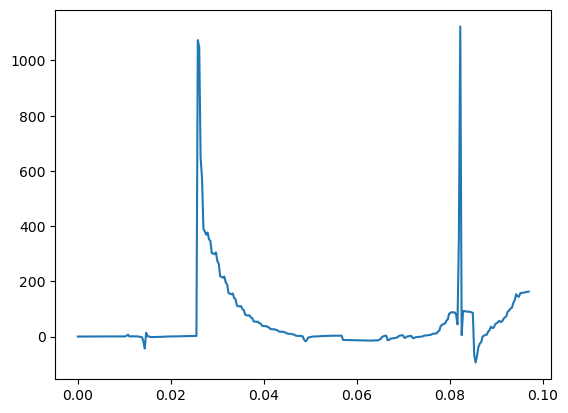

In [72]:
forces_l = np.array(forces)
print(len(forces_l))
print(len(solution1.y[0][0:len(forces_l)]))
work = solution1.y[0][0:len(forces_l)]*vp*T0*forces_l
plt.plot(solution1.t[0:len(work)],work)

plt.plot(solution2.t[0:len(work2)],work2)
plt.plot(solution3.t[0:len(work3)],work3)